**Numerical functions**

In many applications we have do not have access to analytical functions $Y(\boldsymbol{x})$, but rather we have the ability to evaluate them at an arbitrary set of quadrature points $\{\boldsymbol{x}_q\}$. Given that our approach to computing CDF the of $Y(\boldsymbol{x})$
\begin{equation*}
    F(y) = \int_{\Omega} \mathbb{I}(y,\boldsymbol{x}) d \boldsymbol{x},
\end{equation*}
utilises numerical quadrature in order to evaluate a projection of the indicator function given by
\begin{equation*}
    \mathbb{I}(y,\boldsymbol{x}) =
    \begin{cases}
    1 \quad &: Y(\boldsymbol{x}) < y, \\
    0 \quad &: \text{otherwise},
    \end{cases}
\end{equation*}
this implies that by using a sufficiently high degree of numerical quadrature we can exploit the functional form of $Y(\boldsymbol{x})$. In instances where the function is calculated using a psuedo-spectral or finite element method this is therefore particularly powerful.

In this notebook we consider two different examples of how to calculate the CDF from externally generated data. To begin implementing these examples we first import *firedrake* and *Ptp*.

In [1]:
from chist import Ptp
from firedrake import *

**Example 1: numpy function**

As a first example we consider the function 
\begin{equation}
Y(X)  = \frac{\sqrt{2}}{\pi r} a_2 \cos(k x_1) \sin( \pi x_2) - \frac{1}{ r \pi} a_3 \sin(2 \pi x_2),
\end{equation}
corresponding to the buoyancy field used in the Lorenz (1963) model, for which we set the parameters $r=28, k = \pi/\sqrt{2}$ and their amplitudes $a_2 = a_3 = 1$. We implement this below in terms of numpy arrays

In [2]:
import numpy as np

# Parameters
r = 28 
k = np.pi/2**.5

# Amplitudes
a_2 = 1 
a_3 = 1

def Y_numerical(X):
    """Return Y(X)."""
    x1, x2 = X[:,0], X[:,1]
    return ( 2**.5/(np.pi*r) ) * a_2 * np.cos(k*x1) * np.sin(np.pi*x2) - ( 1/(np.pi*r) ) * a_3 * np.sin(2*np.pi*x2)

and then visualise this function on a grid to establish the range of $Y(X)$

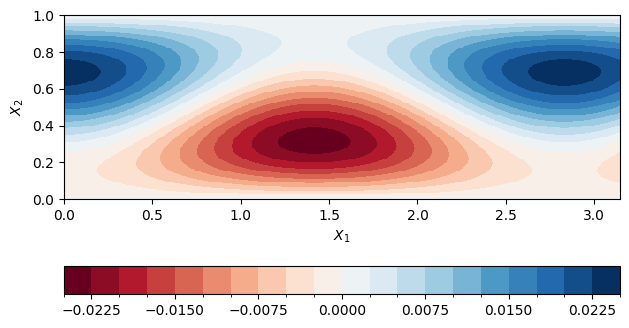

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

dx1, dx2 = 0.005, 0.005
x2, x1 = np.mgrid[slice(0, 1 + dx1, dx1), slice(0, np.pi + dx2, dx2)]

X = np.vstack( (x1.flatten(), x2.flatten())).T
Y = Y_numerical(X).reshape(x2.shape)[:-1, :-1]

levels = MaxNLocator(nbins=20).tick_values(Y.min(), Y.max())
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax0 = plt.subplots()
im = ax0.pcolormesh(x1, x2, Y, cmap=cmap, norm=norm)
ax0.set_xlabel(r'$X_1$')
ax0.set_ylabel(r'$X_2$')
ax0.set_box_aspect(0.33)
fig.colorbar(im, ax=ax0, orientation='horizontal')
fig.tight_layout()
plt.show()

To create the cdf of this function we first create a *Ptp* object by specifying the domain size and the range of the function as indicated in the above figure

In [4]:
ptp = Ptp(Omega_X={'x1': (0, 1), 'x2': (0, np.pi)}, Omega_Y={'Y': (-0.025, 0.025)}, n_elements=50)

We can then pass *Y_numerical* directly to *ptp.fit()* which identifies it as python Callable and therefore first evaulate $Y(\boldsymbol{X})$ on a *Quadrature Element* using a number of points directly determined by the *quadrature_degree* parameter.

firedrake:WARNING Negative slopes could not be removed: min(slope) = -1.048885e-03 



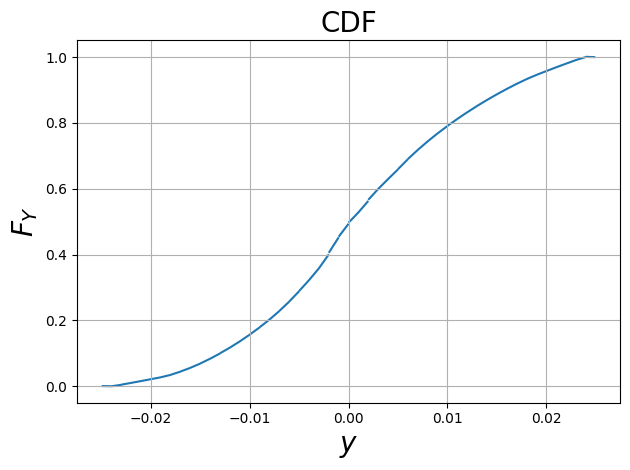

In [5]:
density = ptp.fit(Y_numerical, quadrature_degree=800)
density.plot()

To verify this result we can compare it with the result produced by providing an UFL expression

firedrake:WARNING Negative slopes could not be removed: min(slope) = -1.048885e-03 



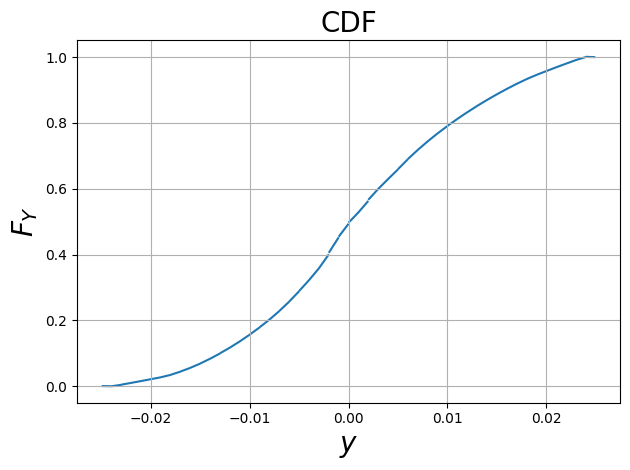

In [6]:
x1, x2 = ptp.x_coords()
Y_anal = ( 2**.5/(np.pi*r) ) * a_2 * cos(k*x1) * sin(np.pi*x2) - ( 1/(np.pi*r) ) * a_3 * sin(2*np.pi*x2)
density = ptp.fit(Y_anal, quadrature_degree)
density.plot()

**Example 2: Finite Element method**

As a second example we compute the cdf of the temperature field $T(\boldsymbol{X})$ generated using *firedrake* as plotted below.

As per the previous example we write a function *Y_numerical* which returns the value of the function at the quadrature points required to perform the evaluation of the cdf. 